In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objs as go

In [19]:
data = yf.download(tickers='BTC-USD', start='2019-01-01')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-12-31,3866.839111,3868.742920,3725.867432,3742.700439,3742.700439,4661840806
2019-01-01,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4324200990
2019-01-02,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5244856836
2019-01-03,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4530215219
2019-01-04,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4847965467
...,...,...,...,...,...,...
2022-02-17,43937.070312,44132.972656,40249.371094,40538.011719,40538.011719,26246662813
2022-02-18,40552.132812,40929.152344,39637.617188,40030.976562,40030.976562,23310007704
2022-02-19,40026.023438,40418.878906,39713.058594,40122.156250,40122.156250,13736557863


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1149 entries, 2018-12-31 to 2022-02-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1149 non-null   float64
 1   High       1149 non-null   float64
 2   Low        1149 non-null   float64
 3   Close      1149 non-null   float64
 4   Adj Close  1149 non-null   float64
 5   Volume     1149 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 62.8 KB


In [27]:
np.round(data.describe(), 2)

,Open,High,Low,Close,Adj Close,Volume
count,1149.00,1149.00,1149.00,1149.00,1149.00,1.149000e+03
mean,22802.37,23399.83,22141.97,22829.03,22829.03,3.203032e+10
std,19154.45,19668.90,18543.95,19145.96,19145.96,2.025161e+10
min,3401.38,3427.95,3391.02,3399.47,3399.47,4.324201e+09
25%,8305.13,8470.99,8172.55,8319.47,8319.47,1.881609e+10
50%,10843.87,11052.77,10622.92,10855.37,10855.37,2.856810e+10
75%,40427.17,41847.16,38862.44,40406.27,40406.27,4.023090e+10
max,67549.73,68789.62,66382.06,67566.83,67566.83,3.509679e+11


In [5]:
import seaborn as sns

<AxesSubplot:>

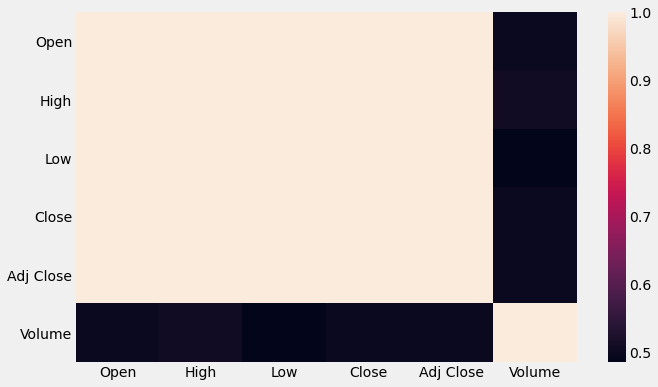

In [28]:
sns.heatmap(data.corr())

In [7]:
data.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.999289,0.998616,0.998192,0.998192,0.500202
High,0.999289,1.000000,0.998547,0.999199,0.999199,0.507603
Low,0.998616,0.998547,1.000000,0.999072,0.999072,0.484394
Close,0.998192,0.999199,0.999072,1.000000,1.000000,0.497655
Adj Close,0.998192,0.999199,0.999072,1.000000,1.000000,0.497655
Volume,0.500202,0.507603,0.484394,0.497655,0.497655,1.000000


In [25]:
fig = go.Figure()

fig.add_trace(go.Candlestick(x=data.index,
                             open=data['Open'],
                             high=data['High'],
                             low=data['Low'],
                             close=data['Close'], name='market data'))
fig.update_layout(
    title='BTC-USD live share price evolution',
    yaxis_title='Stock price (USD per BTC)'
)
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
                      dict(count=3, label='3d', step='day', stepmode='backward'),
                    dict(count=15, label='15d', step='day', stepmode='todate'),
                    dict(count=6, label='6m', step='month', stepmode='backward'),
                      dict(step='all')
        ])
    )
)
fig.show()

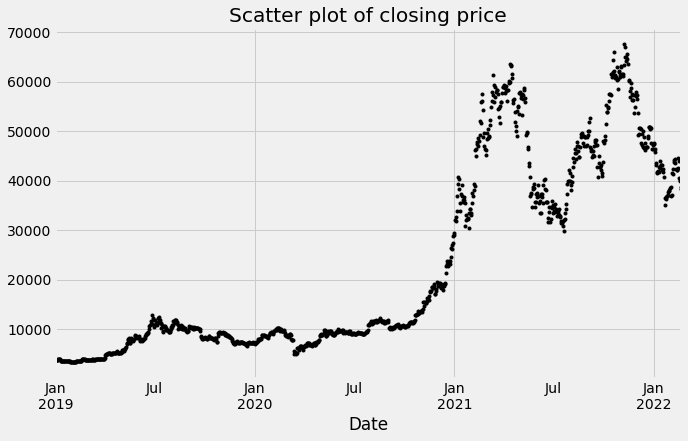

In [29]:
df_close = data['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

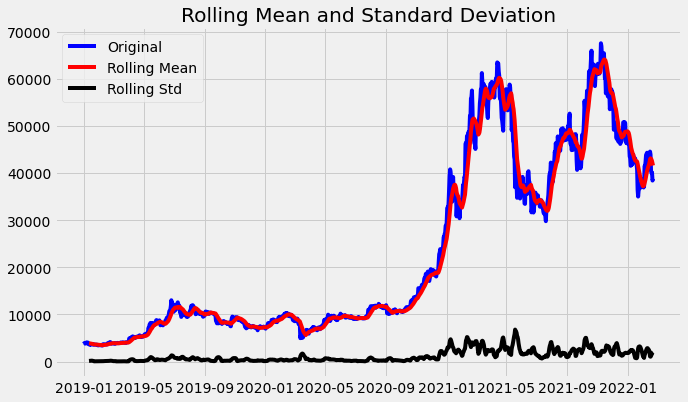

Results of dickey fuller test
Test Statistics                  -1.138574
p-value                           0.699447
No. of lags used                 20.000000
Number of observations used    1128.000000
critical value (1%)              -3.436160
critical value (5%)              -2.864106
critical value (10%)             -2.568136
dtype: float64


In [30]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(data['Close'])

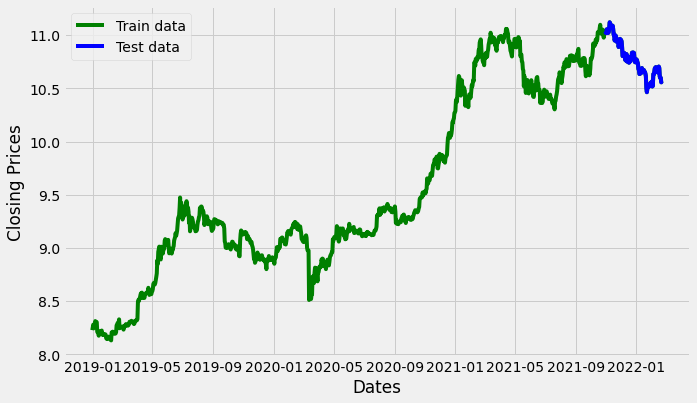

In [32]:
#split data into train and training set
df_log = np.log(data['Close'])
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [33]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3721.890, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3726.345, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3725.849, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3719.107, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3725.957, Time=0.35 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3727.978, Time=0.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3724.882, Time=0.35 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3723.816, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3725.563, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3724.324, Time=1.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-3724.099, Time=0.15 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.987 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:       

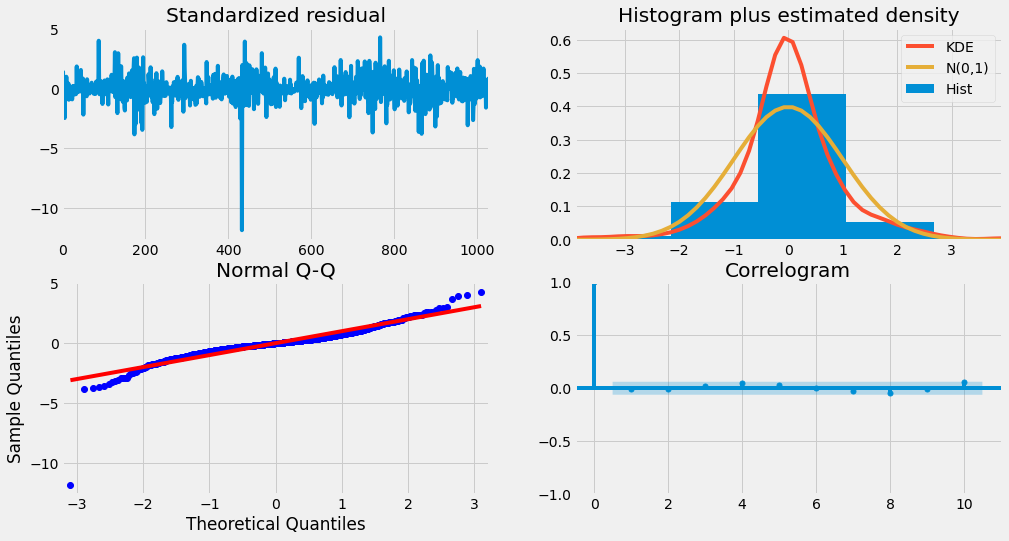

In [34]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [35]:
model = ARIMA(train_data, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Dell\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1030
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1867.989
Method:                       css-mle   S.D. of innovations              0.039
Date:                Mon, 21 Feb 2022   AIC                          -3727.978
Time:                        17:49:44   BIC                          -3708.229
Sample:                    01-04-2019   HQIC                         -3720.483
                         - 10-29-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0027      0.001      2.288      0.022       0.000       0.005
ar.L1.D.Close    -0.7326      0.161     -4.555      0.000      -1.048      -0.417
ma.L1.D.Close     0.6651      0.176     

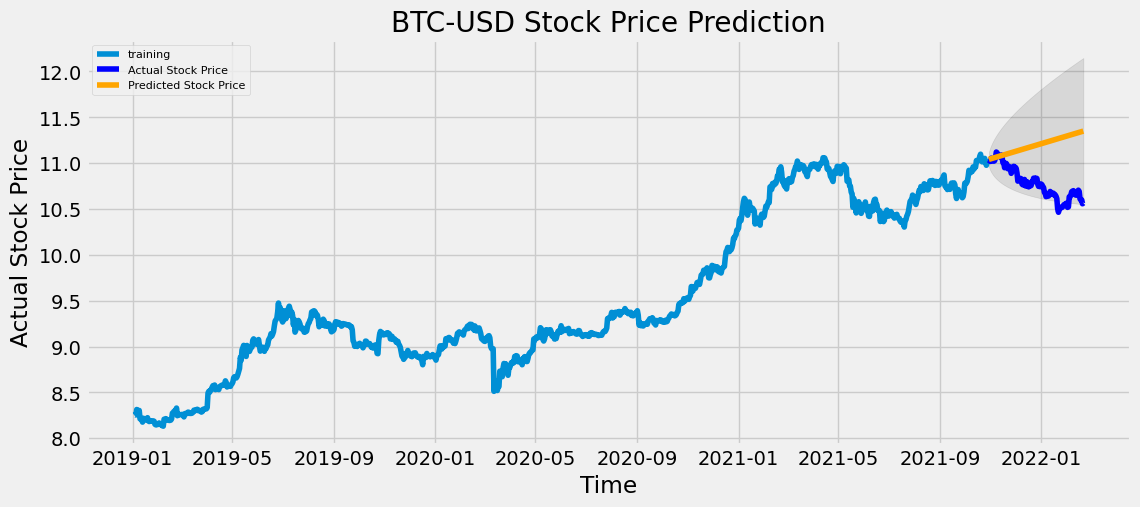

In [37]:
# Forecast
fc, se, conf = fitted.forecast(115, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('BTC-USD Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [38]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.2387027203289891
MAE: 0.41691949067850886
RMSE: 0.48857212397862926
MAPE: 0.03905877392339783
